# Import Stuff

In [41]:
# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# conda install onnx onnxruntime
# pip install torch torchvision numpy opencv-python seaborn matplotlib scikit-learn pillow onnxscript

# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# pip3 install onnx onnxruntime onnxscript ipykernel quanto tqdm
# sudo apt-get install g++ ???????

In [42]:
import os
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import onnx
import onnxruntime
import quanto

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

from matching import matching
from evaluation.metrics import createPR, recallAt100precision, recallAtK
from datasets.load_dataset import GardensPointDataset, SFUDataset, StLuciaDataset

# Constants

In [43]:
WEIGHTS_FILE = "calc.caffemodel.pt"
ITERATIONS = 100 # for testing average duration

# Load Datasets

In [44]:
imgs_db, imgs_q, GThard, GTsoft = SFUDataset().load()
# imgs_db, imgs_q, GThard, GTsoft = GardensPointDataset().load()
# imgs_db, imgs_q, GThard, GTsoft = StLuciaDataset().load()

===== Load dataset SFU dry--jan


# Preprocess Images

In [45]:
class ConvertToYUVandEqualizeHist:
    def __call__(self, img):
        img_yuv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return Image.fromarray(img_rgb)

preprocess = transforms.Compose(
    [
        ConvertToYUVandEqualizeHist(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((120, 160), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
    ]
)

In [46]:
# Preprocess db images

db_tensor = []

for image in imgs_db:
    preprocessed_image = preprocess(image)
    db_tensor.append(preprocessed_image)

db_tensor = torch.stack(db_tensor, axis=0)

# Convert numpy array to a tensor
# query_tensor = torch.from_numpy(query_matrix)

print(db_tensor.shape)
# print(query_tensor)

torch.Size([385, 1, 120, 160])


In [47]:
# Preprocess query images

q_tensor = []

for image in imgs_q:
    preprocessed_image = preprocess(image)
    q_tensor.append(preprocessed_image)

q_tensor = torch.stack(q_tensor, axis=0)

# Convert numpy array to a tensor
# query_tensor = torch.from_numpy(map_matrix)

print(q_tensor.shape)
# print(map_tensor)

torch.Size([385, 1, 120, 160])


# Model Definition

In [48]:
class CalcModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_dim = (1, 120, 160)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5, 5), stride=2, padding=4)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding=2)
        self.relu2 = nn.ReLU(inplace=False)
        self.conv3 = nn.Conv2d(128, 4, kernel_size=(3, 3), stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)


    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.lrn1(x)

        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = self.lrn2(x)

        x = self.relu3(self.conv3(x))
        x = torch.flatten(x, 1)
        return x

### Normal Model

In [49]:
calc = CalcModel()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc.load_state_dict(my_new_state_dict)

print(calc)

CalcModel(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (conv3): Conv2d(128, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
)


### ONNX Model

In [50]:
example_input = torch.randn(1, 1, 120, 160)

dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

# Export the model
torch.onnx.export(
    calc,  # model
    example_input,  # example input
    "calc_model.onnx",  # output file name
    input_names=["input"],  # input names
    output_names=["output"],  # output names
    dynamic_axes=dynamic_axes,  # dynamic axes
)

# Load the ONNX model
ort_session = onnxruntime.InferenceSession("calc_model.onnx")

/home/irfan/.conda/envs/bruh/lib/python3.11/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/irfan/.conda/envs/bruh/lib/python3.11/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/irfan/.conda/envs/bruh/lib/python3.11/site-packages/torch/onnx/utils.py:1208: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/const

### Dynamic Quantized Model (ONNX)

In [51]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType


model_fp32 = 'calc_model.onnx'
model_quant = 'calc_model_quant_dynamic.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)

# Load the dynamic quantized model
ort_session_quant_dynamic = onnxruntime.InferenceSession("calc_model_quant_dynamic.onnx")

  elem_type: 7
  shape {
    dim {
      dim_value: 5
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 5
    }
    dim {
      dim_value: 2
    }
  }
}
.


### Static Quantized Model (ONNX)

In [52]:
# from onnxruntime.tools.symbolic_shape_infer import SymbolicShapeInference

from onnxruntime.quantization.shape_inference import quant_pre_process

quant_pre_process('calc_model.onnx', 'calc_model_quant_static_prep.onnx')

In [53]:
calib_ds = db_tensor[:100] # first 100 for calibration - reserve for quantization
val_ds = db_tensor[100:] # last 100 for validation

print(calib_ds.shape)
print(val_ds.shape)

torch.Size([100, 1, 120, 160])
torch.Size([285, 1, 120, 160])


In [54]:
from onnxruntime.quantization.calibrate import CalibrationDataReader

class QuantizationDataReader(CalibrationDataReader):
    def __init__(self, torch_ds, batch_size, input_name):
        self.torch_dl = torch.utils.data.DataLoader(torch_ds, batch_size=batch_size, shuffle=False)
        self.input_name = input_name
        self.datasize = len(self.torch_dl)
        self.enum_data = iter(self.torch_dl)

    def to_numpy(self, pt_tensor):
        return pt_tensor.detach().cpu().numpy() if pt_tensor.requires_grad else pt_tensor.cpu().numpy()

    def get_next(self):
        batch = next(self.enum_data, None)
        if batch is not None:

            data = self.to_numpy(batch[0])
            data = np.expand_dims(data, axis=0)  # Add a new dimension to the data
            
            return {self.input_name: data}
        else:
            return None

    def rewind(self):
        self.enum_data = iter(self.torch_dl)

qdr = QuantizationDataReader(calib_ds, batch_size=64, input_name=ort_session.get_inputs()[0].name)

In [55]:
from onnxruntime.quantization import quantize_static

q_static_opts = {"ActivationSymmetric":False,
                 "WeightSymmetric":True}
# if torch.cuda.is_available():
#     q_static_opts = {"ActivationSymmetric":True,
#                   "WeightSymmetric":True}

# q_static_opts = {"ActivationSymmetric":False, "WeightSymmetric":False}

# check layer quantization support

quantized_model = quantize_static(model_input='calc_model_quant_static_prep.onnx',
                                               model_output='calc_model_quant_static.onnx',
                                               calibration_data_reader=qdr,
                                               extra_options=q_static_opts)

# Load the static quantized model
ort_session_quant_static = onnxruntime.InferenceSession('calc_model_quant_static.onnx')

### Quantization (Quanto)

In [56]:
calc_quanto = CalcModel()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc_quanto.load_state_dict(my_new_state_dict)

print(calc_quanto)

quanto.quantize(calc_quanto, weights=quanto.qint8, activations=quanto.qint8) # quantization is in place
print(calc_quanto)

CalcModel(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (conv3): Conv2d(128, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
)
CalcModel(
  (conv1): QConv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (relu1): ReLU()
  (conv2): QConv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (conv3): QConv2d(128, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
)


### Torch Compile

In [57]:
# calc_compile = CalcModel()

# # Load the model weights
# state_dict = torch.load(WEIGHTS_FILE)
# my_new_state_dict = {}
# my_layers = list(calc.state_dict().keys())
# for layer in my_layers:
#     my_new_state_dict[layer] = state_dict[layer]
# calc_compile.load_state_dict(my_new_state_dict)

# print(calc_compile)

# calc_torchscript = torch.jit.script(calc_compile)
# print(calc_torchscript)

In [58]:
calc_compile = CalcModel()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc_compile.load_state_dict(my_new_state_dict)

import torch._dynamo
torch._dynamo.reset()

calc_compile = torch.compile(calc_compile, mode="reduce-overhead")

### CUDA Model

In [59]:
torch.cuda.is_available()

# Instantiate the Model
calc_cuda = CalcModel().half().cuda()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc_cuda.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc_cuda.load_state_dict(my_new_state_dict)

<All keys matched successfully>

# Run Models

### Normal Model

In [60]:
# query_tensor = torch.from_numpy(query_matrix)
# map_tensor = torch.from_numpy(map_matrix)

# print(query_tensor.shape)
# print(map_tensor.shape)

# db_tensor = db_tensor.view(-1, 1, 120, 160)
# q_tensor = q_tensor.view(-1, 1, 120, 160)

# Pass the tensors through the model

db_features = calc(db_tensor)
q_features = calc(q_tensor)

print(db_features.shape)
print(q_features.shape)

torch.Size([385, 936])
torch.Size([385, 936])


### Torch Compile

In [61]:
#idk why this is needed
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

db_features_comp = calc_compile(db_tensor)
q_features_comp = calc_compile(q_tensor)

print(db_features_comp.shape)
print(q_features_comp.shape)

skipping cudagraphs due to skipping cudagraphs due to cpu device. Found from : 
   File "/tmp/ipykernel_70348/641759170.py", line 18, in forward
    x = self.relu1(self.conv1(x))



torch.Size([385, 936])
torch.Size([385, 936])


### ONNX Model

In [62]:
# Check if model is a valid ONNX model
onnx_model = onnx.load("calc_model.onnx")
onnx.checker.check_model(onnx_model)

In [63]:
# Convert the tensors to numpy arrays
db_matrix = db_tensor.detach().cpu().numpy()
q_matrix = q_tensor.detach().cpu().numpy()

# ort_session = onnxruntime.InferenceSession("calc_model.onnx")

In [64]:
# Get the input name from the model
input_name = ort_session.get_inputs()[0].name

# Ensure the inputs are numpy arrays
db_matrix = np.array(db_matrix)
q_matrix = np.array(q_matrix)

## Database images

# Create the input dictionary
ort_db_input = {input_name: db_matrix}

# Run the model
ort_db_output = ort_session.run(None, ort_db_input)

# Convert the output to a numpy array and print its shape
ort_db_output = np.array(ort_db_output)
print(ort_db_output.shape)

## Query images

# Create the input dictionary
ort_q_input = {input_name: q_matrix}

# Run the model
ort_q_output = ort_session.run(None, ort_q_input)

# Convert the output to a numpy array and print its shape
ort_q_output = np.array(ort_q_output)
print(ort_q_output.shape)

(1, 385, 936)
(1, 385, 936)


In [65]:
ort_db_output = np.squeeze(ort_db_output)
print(ort_db_output.shape)
ort_q_output = np.squeeze(ort_q_output)
print(ort_q_output.shape)

(385, 936)
(385, 936)


### Dynamic Quantized Model (ONNX)

In [66]:
# Check if model is a valid ONNX model
onnx_model_quant_dynamic = onnx.load("calc_model_quant_dynamic.onnx")
onnx.checker.check_model(onnx_model_quant_dynamic)

In [67]:
ort_session_quant_dynamic = onnxruntime.InferenceSession("calc_model_quant_dynamic.onnx")

In [68]:
# Get the input name from the model
input_name_quant_dynamic = ort_session_quant_dynamic.get_inputs()[0].name

# Ensure the inputs are numpy arrays
db_matrix = np.array(db_matrix)
q_matrix = np.array(q_matrix)

## Database images

# Create the input dictionary
ort_db_input_quant_dynamic = {input_name: db_matrix}

# Run the model
ort_db_output_quant_dynamic = ort_session_quant_dynamic.run(None, ort_db_input_quant_dynamic)

# Convert the output to a numpy array and print its shape
ort_db_output_quant_dynamic = np.array(ort_db_output_quant_dynamic)
print(ort_db_output_quant_dynamic.shape)

## Query images

# Create the input dictionary
ort_q_input_quant_dynamic = {input_name: q_matrix}

# Run the model
ort_q_output_quant_dynamic = ort_session_quant_dynamic.run(None, ort_q_input_quant_dynamic)

# Convert the output to a numpy array and print its shape
ort_q_output_quant_dynamic = np.array(ort_q_output_quant_dynamic)
print(ort_q_output_quant_dynamic.shape)

(1, 385, 936)
(1, 385, 936)


### Static Quantized Model (ONNX)

In [69]:
# Check if model is a valid ONNX model
onnx_model_quant_static = onnx.load("calc_model_quant_static.onnx")
onnx.checker.check_model(onnx_model_quant_static)

In [70]:
ort_session_quant_static = onnxruntime.InferenceSession("calc_model_quant_static.onnx")

In [71]:
# Get the input name from the model
input_name_quant_static = ort_session_quant_static.get_inputs()[0].name

# Ensure the inputs are numpy arrays
db_matrix = np.array(db_matrix)
q_matrix = np.array(q_matrix)

## Database images

# Create the input dictionary
ort_db_input_quant_static = {input_name: db_matrix}

# Run the model
ort_db_output_quant_static = ort_session_quant_static.run(None, ort_db_input_quant_static)

# Convert the output to a numpy array and print its shape
ort_db_output_quant_static = np.array(ort_db_output_quant_static)
print(ort_db_output_quant_static.shape)

## Query images

# Create the input dictionary
ort_q_input_quant_static = {input_name: q_matrix}

# Run the model
ort_q_output_quant_static = ort_session_quant_static.run(None, ort_q_input_quant_static)

# Convert the output to a numpy array and print its shape
ort_q_output_quant_static = np.array(ort_q_output_quant_static)
print(ort_q_output_quant_static.shape)

(1, 385, 936)
(1, 385, 936)


### CUDA Model

In [72]:
# Pass the tensors through the model

db_features_cuda = calc_cuda(db_tensor.half().cuda())
q_features_cuda = calc_cuda(q_tensor.half().cuda())

db_features_cuda = db_features_cuda.detach().cpu()
q_features_cuda = q_features_cuda.detach().cpu()

print(db_features_cuda.shape)
print(q_features_cuda.shape)

torch.Size([385, 936])
torch.Size([385, 936])


# Average Time

### Normal Model

In [73]:
# Average time for database tensor

start_time = time.time()

for _ in range(ITERATIONS):
    output = calc(db_tensor)

end_time = time.time()

db_time = end_time - start_time
db_avg_time = db_time / ITERATIONS

print(f"Time taken: {db_time} seconds")
print(f"Average time taken: {db_avg_time} seconds")

# Average time for map tensor

start_time = time.time()

for _ in range(ITERATIONS):
    with torch.no_grad():
        output = calc(q_tensor)

end_time = time.time()

q_time = end_time - start_time
q_avg_time = q_time / ITERATIONS

print(f"Time taken: {q_time} seconds")
print(f"Average time taken: {q_avg_time} seconds")

Time taken: 48.63753652572632 seconds
Average time taken: 0.48637536525726316 seconds
Time taken: 46.152939796447754 seconds
Average time taken: 0.46152939796447756 seconds


### Torch Compile

In [74]:
# Average time for database tensor

start_time = time.time()

for _ in range(ITERATIONS):
    output = calc_compile(db_tensor)

end_time = time.time()

db_time = end_time - start_time
db_avg_time = db_time / ITERATIONS

print(f"Time taken: {db_time} seconds")
print(f"Average time taken: {db_avg_time} seconds")

# Average time for map tensor

start_time = time.time()

for _ in range(ITERATIONS):
    with torch.no_grad():
        output = calc_compile(q_tensor)

end_time = time.time()

q_time = end_time - start_time
q_avg_time = q_time / ITERATIONS

print(f"Time taken: {q_time} seconds")
print(f"Average time taken: {q_avg_time} seconds")

Time taken: 36.191163301467896 seconds
Average time taken: 0.36191163301467894 seconds


skipping cudagraphs due to skipping cudagraphs due to cpu device. Found from : 
   File "/tmp/ipykernel_70348/641759170.py", line 18, in forward
    x = self.relu1(self.conv1(x))



Time taken: 28.220376014709473 seconds
Average time taken: 0.28220376014709475 seconds


### ONNX Model

In [75]:
# Average time for database tensor

input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: db_matrix}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs = ort_session.run(None, ort_inputs)

end_time = time.time()

db_time_onnx = end_time - start_time
db_avg_time_onnx = db_time_onnx / ITERATIONS

print(f"Time taken: {db_time_onnx} seconds")
print(f"Average time taken: {db_avg_time_onnx} seconds")

# Average time for query tensor

input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: q_matrix}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs = ort_session.run(None, ort_inputs)

end_time = time.time()

q_time_onnx = end_time - start_time
q_avg_time_onnx = q_time_onnx / ITERATIONS

print(f"Time taken: {q_time_onnx} seconds")
print(f"Average time taken: {q_avg_time_onnx} seconds")

Time taken: 20.546537399291992 seconds
Average time taken: 0.20546537399291992 seconds
Time taken: 20.47860360145569 seconds
Average time taken: 0.2047860360145569 seconds


### Dynamic Quantized Model (ONNX)
Bad Results?

In [76]:
# Average time for database tensor

input_name_quant_dynamic = ort_session_quant_dynamic.get_inputs()[0].name
ort_inputs_quant_dynamic = {input_name_quant_dynamic: db_matrix}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs_quant_dynamic = ort_session_quant_dynamic.run(None, ort_inputs_quant_dynamic)

end_time = time.time()

db_time_onnx_quant_dynamic = end_time - start_time
db_avg_time_onnx_quant_dynamic = db_time_onnx_quant_dynamic / ITERATIONS

print(f"Time taken: {db_time_onnx_quant_dynamic} seconds")
print(f"Average time taken: {db_avg_time_onnx_quant_dynamic} seconds")

# Average time for query tensor

input_name_quant_dynamic = ort_session_quant_dynamic.get_inputs()[0].name
ort_inputs_quant_dynamic = {input_name_quant_dynamic: q_matrix}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs_quant_dynamic = ort_session_quant_dynamic.run(None, ort_inputs)

end_time = time.time()

q_time_onnx_quant_dynamic = end_time - start_time
q_avg_time_onnx_quant_dynamic = q_time_onnx_quant_dynamic / ITERATIONS

print(f"Time taken: {q_time_onnx_quant_dynamic} seconds")
print(f"Average time taken: {q_avg_time_onnx_quant_dynamic} seconds")

Time taken: 38.906824827194214 seconds
Average time taken: 0.38906824827194214 seconds
Time taken: 38.87888169288635 seconds
Average time taken: 0.3887888169288635 seconds


### Static Quantized Model

In [77]:
# Average time for database tensor

input_name_quant_static = ort_session_quant_static.get_inputs()[0].name
ort_inputs_quant_static = {input_name_quant_static: db_matrix}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs_quant_static = ort_session_quant_static.run(None, ort_inputs_quant_static)

end_time = time.time()

db_time_onnx_quant_static = end_time - start_time
db_avg_time_onnx_quant_static = db_time_onnx_quant_static / ITERATIONS

print(f"Time taken: {db_time_onnx_quant_static} seconds")
print(f"Average time taken: {db_avg_time_onnx_quant_static} seconds")

# Average time for query tensor

input_name_quant_static = ort_session_quant_static.get_inputs()[0].name
ort_inputs_quant_static = {input_name_quant_static: q_matrix}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs_quant_static = ort_session_quant_static.run(None, ort_inputs)

end_time = time.time()

q_time_onnx_quant_static = end_time - start_time
q_avg_time_onnx_quant_static = q_time_onnx_quant_static / ITERATIONS

print(f"Time taken: {q_time_onnx_quant_static} seconds")
print(f"Average time taken: {q_avg_time_onnx_quant_static} seconds")

Time taken: 38.28216791152954 seconds
Average time taken: 0.3828216791152954 seconds
Time taken: 38.68071484565735 seconds
Average time taken: 0.3868071484565735 seconds


### CUDA Model

In [78]:
start_time = time.time()

# Average time for database tensor

for _ in range(ITERATIONS):
    output = calc_cuda(db_tensor.half().cuda())

end_time = time.time()

db_time_cuda = end_time - start_time
db_avg_time_cuda = db_time_cuda / ITERATIONS

print(f"Time taken: {db_time_cuda} seconds")
print(f"Average time taken: {db_avg_time_cuda} seconds")

# Average time for query tensor

start_time = time.time()

for _ in range(ITERATIONS):
    output = calc_cuda(q_tensor.half().cuda())

end_time = time.time()

q_time_cuda = end_time - start_time
q_avg_time_cuda = q_time_cuda / ITERATIONS

print(f"Time taken: {q_time_cuda} seconds")
print(f"Average time taken: {q_avg_time_cuda} seconds")

Time taken: 2.8009355068206787 seconds
Average time taken: 0.028009355068206787 seconds
Time taken: 2.8182475566864014 seconds
Average time taken: 0.028182475566864013 seconds


# Evaluation

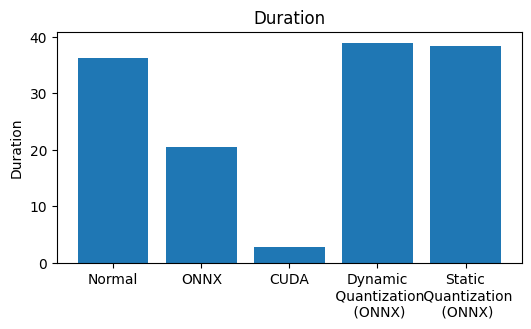

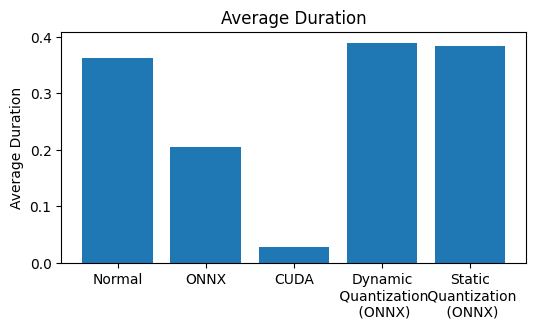

In [79]:
import matplotlib.pyplot as plt

# Variables
models = ['Normal', 'ONNX', 'CUDA', 'Dynamic\n Quantization\n (ONNX)', 'Static\n Quantization\n (ONNX)']
durations = [db_time, db_time_onnx, db_time_cuda, db_time_onnx_quant_dynamic, db_time_onnx_quant_static]
avg_durations = [db_avg_time, db_avg_time_onnx, db_avg_time_cuda, db_avg_time_onnx_quant_dynamic, db_avg_time_onnx_quant_static]

# Plot duration bar chart
plt.figure(figsize=(6, 3))
plt.bar(models, durations)
plt.title('Duration')
plt.ylabel('Duration')
plt.show()

# Plot average duration bar chart
plt.figure(figsize=(6, 3))
plt.bar(models, avg_durations)
plt.title('Average Duration')
plt.ylabel('Average Duration')
plt.show()

In [80]:
# precision-recall curve
# P, R = createPR(similarity_matrix, GThard, GTsoft, matching='multi', n_thresh=100)
# plt.figure()
# plt.plot(R, P)
# plt.xlim(0, 1), plt.ylim(0, 1.01)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Result on GardensPoint day_right--night_right')
# plt.grid('on')
# plt.draw()
# plt.show()